In [1]:
#============================= IMPORT LIBRARIES =============================

import pandas as pd
import re
import warnings
warnings.filterwarnings("ignore")
from sklearn import naive_bayes

#============================= DATA SELECTION ==============================

dataframe=pd.read_csv("Restaurant reviews.csv")
print("==============================================")
print("------------------- Input Data ---------------")
print("==============================================")
print()
print(dataframe.head(20))


------------------- Input Data ---------------

         Restaurant              Reviewer  \
0   Beyond Flavours     Rusha Chakraborty   
1   Beyond Flavours  Anusha Tirumalaneedi   
2   Beyond Flavours       Ashok Shekhawat   
3   Beyond Flavours        Swapnil Sarkar   
4   Beyond Flavours                Dileep   
5   Beyond Flavours         Nagabhavani K   
6   Beyond Flavours       Jamuna Bhuwalka   
7   Beyond Flavours             Sandhya S   
8   Beyond Flavours          Akash Thorat   
9   Beyond Flavours        Smarak Patnaik   
10  Beyond Flavours      Saubhagya Bhuyan   
11  Beyond Flavours            Srivaths07   
12  Beyond Flavours           Kunj Mishra   
13  Beyond Flavours     Pradeep Vetapalem   
14  Beyond Flavours         Kankaria.ritu   
15  Beyond Flavours          Abhay Sharma   
16  Beyond Flavours       Shubham Jaiswal   
17  Beyond Flavours     Srijani Mukherjee   
18  Beyond Flavours           Hari Jangam   
19  Beyond Flavours           Suneet Soni   

      

In [2]:
#============================= PREPROCESSING ==============================

#==== checking missing values ====

print("============================================================")
print("------------------  Before Checking Missing Values ---------")
print("=============================================================")
print()
print(dataframe.isnull().sum())

print("===============================================================")
print("------------------  After Checking Missing Values -------==--")
print("==============================================================")
print()
dataframe=dataframe.fillna(0)
print(dataframe.isnull().sum())

------------------  Before Checking Missing Values ---------

Restaurant     0
Reviewer      38
Review        45
Rating        38
Metadata      38
Time          38
Pictures       0
dtype: int64
------------------  After Checking Missing Values -------==--

Restaurant    0
Reviewer      0
Review        0
Rating        0
Metadata      0
Time          0
Pictures      0
dtype: int64


In [3]:
#============================= TEXT PREPROCESSING ==============================

print("=======================================================")
print("------------------  Applying NLP Techniques -------==--")
print("======================================================")
print()


# remove the unwanted spaces and strip sentence 

cleanup_re = re.compile('[^a-z]+')
def cleanup(sentence):
    sentence = str(sentence)
    sentence = sentence.lower()
    sentence = cleanup_re.sub(' ', sentence).strip()
    return sentence

print("=======================================================")
print("------------------- Before NLP techniques  -------==--")
print("======================================================")
print()
print(dataframe["Review"].head(10))

print("=======================================================")
print("------------------- Removing Punctuations -------==--")
print("======================================================")
print()

dataframe["clean_text"] = dataframe["Review"].apply(cleanup)
print(dataframe["clean_text"].head(10))

------------------  Applying NLP Techniques -------==--

------------------- Before NLP techniques  -------==--

0    The ambience was good, food was quite good . h...
1    Ambience is too good for a pleasant evening. S...
2    A must try.. great food great ambience. Thnx f...
3    Soumen das and Arun was a great guy. Only beca...
4    Food is good.we ordered Kodi drumsticks and ba...
5    Ambiance is good, service is good, food is aPr...
6    Its a very nice place, ambience is different, ...
7    Well after reading so many reviews finally vis...
8    Excellent food , specially if you like spicy f...
9    Came for the birthday treat of a close friend....
Name: Review, dtype: object
------------------- Removing Punctuations -------==--

0    the ambience was good food was quite good had ...
1    ambience is too good for a pleasant evening se...
2    a must try great food great ambience thnx for ...
3    soumen das and arun was a great guy only becau...
4    food is good we ordered kodi 

In [4]:
#=================== SENTIMENT ANALYSIS ==========================

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer    

#initialize the sentiment analyzer function
analyzer = SentimentIntensityAnalyzer()

#calculate the positive,negative,neutral values
dataframe['compound'] = [analyzer.polarity_scores(x)['compound'] for x in dataframe['clean_text']]
dataframe['neg'] = [analyzer.polarity_scores(x)['neg'] for x in dataframe['clean_text']]
dataframe['neu'] = [analyzer.polarity_scores(x)['neu'] for x in dataframe['clean_text']]
dataframe['pos'] = [analyzer.polarity_scores(x)['pos'] for x in dataframe['clean_text']]

dataframe['comp_score'] = dataframe['compound'].apply(lambda c: 0 if c >=0 else 1)

comp_score=[]
for i in range(0,len(dataframe['compound'])):

    if dataframe['compound'][i] >= 0.05 :
            # print("Positive")
            comp_score.append(0)
     
    elif dataframe['compound'][i] <= - 0.05 :
            # print("Negative")
            comp_score.append(1)

     
    else :
            # print("Neutral")
            comp_score.append(2)


In [5]:
#============================= DATA SPLITTING ==============================

x=dataframe["clean_text"]
y=comp_score

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.4,random_state = 42)


print("----------------------------------------------")
print("================= Data Splitting  =============")
print("----------------------------------------------")
print()

print("Total number of rows in dataset:", dataframe.shape[0])
print()
print("Total number of rows in training data:", x_train.shape[0])
print()
print("Total number of rows in testing data:", x_test.shape[0])


----------------------------------------------
================= Data Splitting  =============
----------------------------------------------

Total number of rows in dataset: 10000

Total number of rows in training data: 6000

Total number of rows in testing data: 4000


In [6]:
#============================= VECTORIZATION ==============================

from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer

#CountVectorizer method
bow_trans = CountVectorizer(analyzer=cleanup).fit(dataframe["clean_text"])

# print(len(bow_trans.vocabulary_))
msg_bow = bow_trans.transform(dataframe["clean_text"])

tfidf_transformer = TfidfTransformer().fit(msg_bow)

msg_tfidf = tfidf_transformer.transform(msg_bow)

In [7]:
# ============= Resturanat ======

# === XGBOOST  =====

from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

pipeline_xgb = Pipeline([
    ('bow', CountVectorizer(analyzer=cleanup)),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', XGBClassifier()),  
])

xg= XGBClassifier()

pipeline_xgb.fit(x_train, y_train)

#=== predict the model ===
y_pred_xgb = pipeline_xgb.predict(x_train)

from sklearn import metrics

acc_xgb=metrics.accuracy_score(y_train,y_pred_xgb)


print("============ Performance Analysis =========")
print()
print(" Accuracy :",acc_xgb*100,'%')
print()
print(metrics.classification_report(y_pred_xgb,y_train))
print()

============ Performance Analysis =========

 Accuracy : 99.95 %

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4483
           1       1.00      1.00      1.00      1082
           2       1.00      1.00      1.00       435

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000




In [8]:
# ===== DECISION TREE =====

from sklearn.tree import DecisionTreeClassifier

pipeline_dt = Pipeline([
    ('bow', CountVectorizer(analyzer=cleanup)),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', DecisionTreeClassifier()),  
])

pipeline_dt.fit(x_train, y_train)

#=== predict the model ===
y_pred_dt = pipeline_dt.predict(x_train)

from sklearn import metrics

acc_dt=metrics.accuracy_score(y_train,y_pred_dt)


print("============ Performance Analysis =========")
print()
print(" Accuracy :",acc_dt*100,'%')
print()
print(metrics.classification_report(y_pred_dt,y_train))
print()


============ Performance Analysis =========

 Accuracy : 99.98333333333333 %

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4481
           1       1.00      1.00      1.00      1086
           2       1.00      1.00      1.00       433

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000




In [9]:
# ====== 

rest_name="Beyond Flavours"

a=rest_name

data_label=dataframe['Restaurant']


x1=data_label
for i in range(0,len(dataframe)):
    if x1[i]==a:
        idx=i   
    
    
data_frame1_c=dataframe['Review']

data_frame1_c1=dataframe['Rating']


Req_data_c=data_frame1_c[idx]

Req_data_c1=data_frame1_c1[idx]


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid_obj = SentimentIntensityAnalyzer()

sentiment_dict = sid_obj.polarity_scores(Req_data_c)

if sentiment_dict['compound'] >= 0.05 :
    aa="POSITIVE"
    print("POSITIVE")
 
elif sentiment_dict['compound'] <= - 0.05 :
    aa="NEGATIVE"
    print("NEGATIVE")
else:
    aa="NEUTRAL"
    print("NEUTRAL")

NEUTRAL


In [10]:
# ===

print("--------------------------------")
print("Best Restuarant ")
print("--------------------------------")
import numpy as np
data_label_unique = np.unique(data_label)
temp = []
temprate = []

max_rating_temp = []

for ii in range(0,len(data_label_unique)):
    temp = np.where(dataframe['Restaurant'] == data_label_unique[ii])
    temprate.append(dataframe['Rating'][temp[0]])
    max_rating_temp.append(sum(temprate[ii] == '5'))

rate_index = np.where(max_rating_temp == np.max(max_rating_temp))

print('Maximum Rating Restaurant = ',data_label[rate_index[0]])

--------------------------------
Best Restuarant 
--------------------------------
Maximum Rating Restaurant =  3    Beyond Flavours
Name: Restaurant, dtype: object


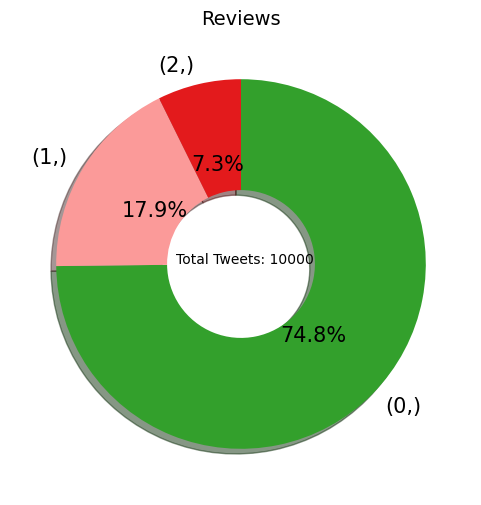

In [11]:
y=pd.DataFrame(y)
#pie graph
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (6,6))
counts = y.value_counts()
plt.pie(counts, labels = counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6},autopct='%1.1f%%', pctdistance = 0.55, textprops = {'color': 'black', 'fontsize' : 15}, shadow = True,colors = sns.color_palette("Paired")[3:])
plt.text(x = -0.35, y = 0, s = 'Total Tweets: {}'.format(dataframe.shape[0]))
plt.title('Reviews', fontsize = 14);
plt.show()